In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
column_names = ["Timestamp", "Open", "High", "Low", "Close", "Volume"]
file_path = "BTCUSDT.csv"

df = pd.read_csv(file_path, names=column_names, header=None)
print(df.head())  # Muestra las primeras filas para verificar

                                                             Timestamp  \
1502942400000 4261.48 4313.62 4261.32 4308.83 47.181009  1502945999999   
1502946000000 4308.83 4328.69 4291.37 4315.32 23.234916  1502949599999   
1502949600000 4330.29 4345.45 4309.37 4324.35 7.229691   1502953199999   
1502953200000 4316.62 4349.99 4287.41 4349.99 4.443249   1502956799999   
1502956800000 4333.32 4377.85 4333.32 4360.69 0.972807   1502960399999   

                                                                  Open  High  \
1502942400000 4261.48 4313.62 4261.32 4308.83 47.181009  202366.138393   171   
1502946000000 4308.83 4328.69 4291.37 4315.32 23.234916  100304.823567   102   
1502949600000 4330.29 4345.45 4309.37 4324.35 7.229691    31282.312670    36   
1502953200000 4316.62 4349.99 4287.41 4349.99 4.443249    19241.058300    25   
1502956800000 4333.32 4377.85 4333.32 4360.69 0.972807     4239.503586    28   

                                                               Low  \
1502

In [5]:
df["Timestamp"] = pd.to_numeric(df["Timestamp"], errors="coerce")

# Verificar si los timestamps son demasiado grandes (probablemente en milisegundos)
df = df[df["Timestamp"] > 1000000000]  # Filtrar valores irreales

# Si están en milisegundos, convertirlos a segundos
if df["Timestamp"].max() > 10**12:
    df["Timestamp"] = df["Timestamp"] // 1000  # Convertir milisegundos a segundos

# Ahora convertir a fecha sin errores
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")

In [6]:
df["Price_Change"] = df["Close"] - df["Open"]
df["High_Low_Spread"] = df["High"] - df["Low"]
df["Pct_Change"] = df["Close"].pct_change()
df["Future_Close"] = df["Close"].shift(-1)

In [7]:
df["Signal"] = np.where(df["Future_Close"] > df["Close"], 1, 0)  # 1 = Comprar, 0 = Vender
df.dropna(inplace=True)

In [8]:
features = ["Open", "Close", "High", "Low", "Volume", "Price_Change", "High_Low_Spread", "Pct_Change"]
X = df[features].values
y = df["Signal"].values

In [9]:
# Eliminar valores infinitos y reemplazar NaN con la media de la columna
X = np.where(np.isfinite(X), X, np.nan)  # Reemplazar Inf y -Inf con NaN
X = np.nan_to_num(X, nan=np.nanmean(X))  # Reemplazar NaN con la media de la columna

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
def create_sequences(X, y, seq_length=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 10  # Usamos los últimos 10 días para predecir
X_seq, y_seq = create_sequences(X_scaled, y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)

In [12]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1, activation="sigmoid")  # Clasificación binaria (0 o 1)
])

c:\Users\germa\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n📈 Precisión del modelo: {accuracy:.2f}")

Epoch 1/50
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5317 - loss: 0.6914 - val_accuracy: 0.5304 - val_loss: 0.6905
Epoch 2/50
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5269 - loss: 0.6905 - val_accuracy: 0.5302 - val_loss: 0.6879
Epoch 3/50
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5318 - loss: 0.6877 - val_accuracy: 0.5360 - val_loss: 0.6867
Epoch 4/50
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5355 - loss: 0.6852 - val_accuracy: 0.5337 - val_loss: 0.6872
Epoch 5/50
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5377 - loss: 0.6844 - val_accuracy: 0.5355 - val_loss: 0.6849
Epoch 6/50
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5456 - loss: 0.6828 - val_accuracy: 0.5443 - val_loss: 0.6846
Epoch 7/50
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5443 - loss: 0.6828 - val_accuracy: 0.5418 - val_loss: 0.6836
Epoch 8/50
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5446 - loss: 0.6824 -

In [24]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convertimos a 0 o 1

408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [25]:
df = df.iloc[seq_length:]  # Alinear datos con predicciones
df["Prediction"] = y_pred

ValueError: Length of values (13047) does not match length of index (65223)

C:\Users\germa\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


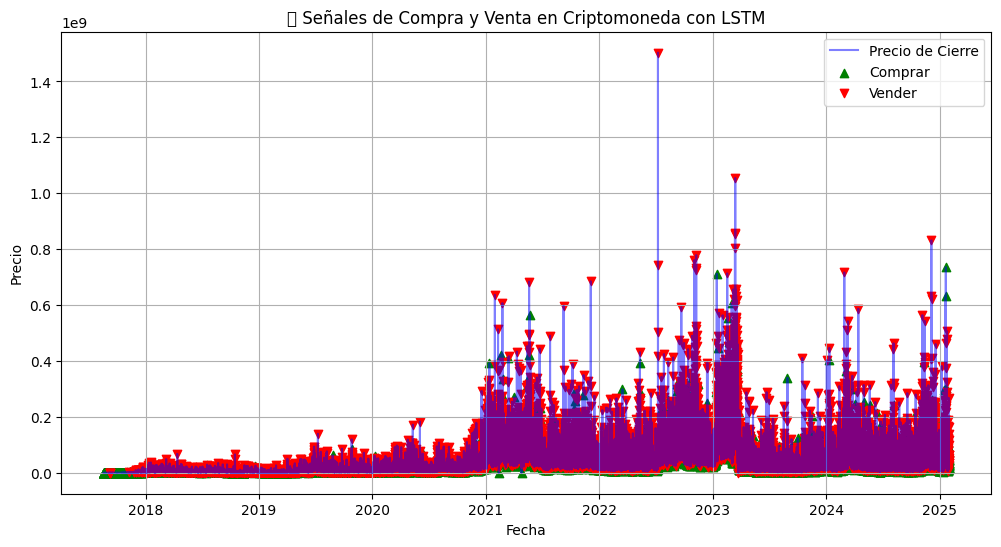

In [26]:
plt.figure(figsize=(12,6))
plt.plot(df["Timestamp"], df["Close"], label="Precio de Cierre", color="blue", alpha=0.5)

plt.scatter(df[df["Prediction"] == 1]["Timestamp"], df[df["Prediction"] == 1]["Close"],
            color="green", label="Comprar", marker="^", alpha=1)

plt.scatter(df[df["Prediction"] == 0]["Timestamp"], df[df["Prediction"] == 0]["Close"],
            color="red", label="Vender", marker="v", alpha=1)

plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("📊 Señales de Compra y Venta en Criptomoneda con LSTM")
plt.legend()
plt.grid()
plt.show()

In [28]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"\n📊 Precisión del modelo: {accuracy:.2f}"
      f"\n📊 Puntuación F1: {f1:.2f}")


📊 Precisión del modelo: 0.55
📊 Puntuación F1: 0.55


65233
